<a href="https://colab.research.google.com/github/GaganSingh5/produce-sync-image-classifier/blob/main/produce_sync_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# dependencies of the project.
import os
import json
from PIL import Image
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [ ]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive/tomatoesdataset/

example_dataset.yaml  train  val


In [ ]:
def loadDataset(rootPath, annotationsPath, imageDatasetPath):
  dataset = []
  annotationsFullPath = os.path.join(rootPath, annotationsPath)
  imageDatasetFullPath = os.path.join(rootPath, imageDatasetPath)

  for filename in os.listdir(annotationsFullPath):
    if filename.endswith('.json'):
      with open(os.path.join(annotationsFullPath, filename), 'r') as f:
        annotationJSON = json.load(f)
        # print(annotationJSON)
        images = annotationJSON["images"]
        annotations = annotationJSON["annotations"]
        for image in images:
          id = image["id"];
          filteredAnnotations = [anno for anno in annotations if anno["image_id"] == id]
          image["file_name"] = os.path.join(imageDatasetFullPath, image["file_name"])
          # imageObj = cv2.imread(imagePath)
          dataset.append({'image': image, 'annotations': filteredAnnotations})

  return dataset;

dataset = loadDataset("drive/MyDrive/tomatoesdataset/train", "annotations/", "images/")

print(dataset[0])

{'image': {'license': 1, 'file_name': 'drive/MyDrive/tomatoesdataset/train/images/IMG_20191215_111114.jpg', 'coco_url': 'https://storage.yandexcloud.net/tomatoes/for_test/Big/IMG_20191215_111114.jpg', 'height': 4160, 'width': 3120, 'date_captured': 'none', 'flickr_url': 'none', 'id': 0}, 'annotations': [{'segmentation': [[1616.8775999999998, 1374.8384, 1609.8264000000001, 1269.0496, 1609.8264000000001, 1177.4048, 1647.4224000000002, 1088.0896, 1692.0696, 1024.6496, 1753.1904, 989.4144, 1835.4336, 951.808, 1908.2856, 947.1072, 1988.1888000000001, 958.8384, 2044.5984, 970.6112, 2112.7392, 1001.1456000000001, 2192.6736, 1071.6576, 2253.7632, 1153.9008000000001, 2272.5768, 1231.4432, 2267.8656, 1320.7584, 2260.8144, 1405.3728, 2223.2184, 1485.2864000000002, 2169.1488, 1544.0256, 2077.5144, 1593.3632, 1948.2528, 1621.568, 1851.9071999999999, 1635.6704, 1734.3768, 1579.2608, 1647.4224000000002, 1464.1119999999999]], 'area': 362918.13442559936, 'iscrowd': 0, 'image_id': 0, 'bbox': [1609.82640

In [ ]:
# Generate segmentation mask from points
def generate_mask(image_size, points):
    mask = np.zeros(image_size, dtype=np.uint8)
    for point in points:
        x, y = point
        mask[y, x] = 1  # Set pixel to 1 (foreground)
    return mask

In [ ]:
def colorByCategory(category):
  if (category == 6 or category == 3):
    return "green"

  if (category == 1 or category == 4):
    return "red"

  if (category == 2 or category == 5):
    return "yellow"

  return "none"

In [ ]:
def annotatedImages(dataset):
  image = cv2.imread(dataset["image"]["file_name"])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image.rotate(270)
  annot = dataset["annotations"]
  plt.imshow(image)
  for anno in annot:
    x, y, w, h = anno["bbox"]
    rect = patches.Rectangle((x, y), w, h, linewidth=0.5, edgecolor=colorByCategory(anno["category_id"]), facecolor='none')
    plt.gca().add_patch(rect)
    segmentationdata = anno["segmentation"]
      # Reshape the segmentation data into pairs of (x, y) coordinates
    segmentation_mask = np.array(segmentationdata).reshape(-1, 2)
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates

    # Create a polygon patch
    polygon = patches.Polygon(segmentation_mask, edgecolor=colorByCategory(anno["category_id"]), facecolor=colorByCategory(anno["category_id"]), alpha=0.3)

    # Add the polygon patch to the plot
    plt.gca().add_patch(polygon)

    # Plot the segmentation mask

  plt.axis('off')  # Turn off axis
  plt.show()

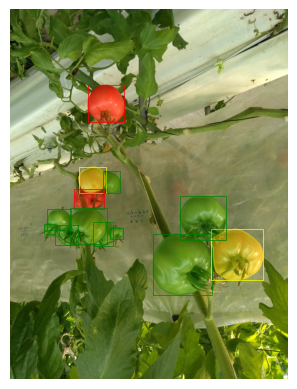

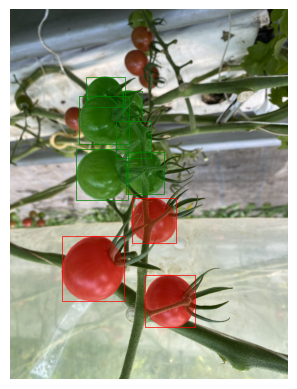

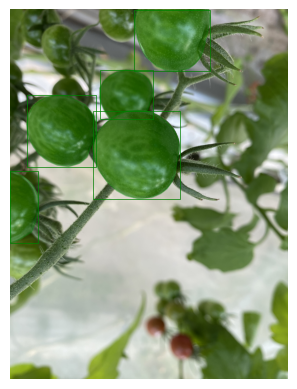

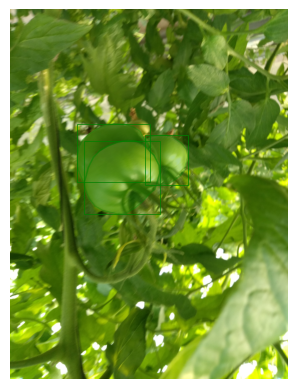

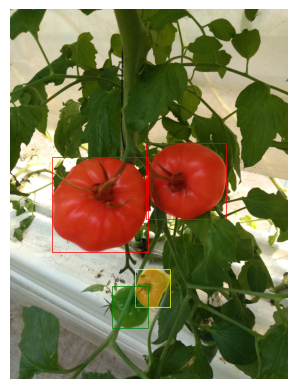

In [ ]:

for i in range(0, 5):
  annotatedImages(dataset[i])


In [13]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
root_dir = "drive/MyDrive/tomatoesdataset"
tfrecords_dir = "drive/MyDrive/tomatoesdataset/train/tfrecords"
images_dir = os.path.join(root_dir, "train/images")
annotations_dir = os.path.join(root_dir, "train/annotations")
annotation_file = os.path.join(annotations_dir, "train.json")


In [18]:
with open(annotation_file, "r") as f:
    train_annotations = json.load(f)


annotations = train_annotations["annotations"]
images = train_annotations["images"]

In [9]:
print(annotations[60])

{'segmentation': [[1174.40064, 2408.3942399999996, 1183.5331199999998, 2466.09216, 1177.45488, 2514.67776, 1153.1419199999998, 2569.35168, 1107.60048, 2608.86528, 1062.0287999999998, 2645.27424, 1007.3548799999999, 2666.5632, 931.4524799999999, 2663.49888, 879.80256, 2636.16192, 837.28512, 2593.66464, 806.9241599999999, 2520.76608, 800.84592, 2453.95584, 828.1828799999998, 2381.05728, 882.8568000000001, 2326.3833600000003, 952.7112000000002, 2305.13472, 1010.4091200000001, 2289.93408, 1086.34176, 2314.2470399999997, 1131.8832, 2347.67232]], 'area': 109437.39992586314, 'iscrowd': 0, 'image_id': 7, 'bbox': [800.84592, 2289.93408, 382.68719999999985, 376.62912000000006], 'category_id': 4, 'id': 60}


In [10]:
num_samples = 4096
num_tfrecords = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecords += 1  # add one record if there are any remaining samples

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)  # creating TFRecords output folder

In [11]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

In [19]:
for tfrec_num in range(num_tfrecords):
    samples = annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]

    with tf.io.TFRecordWriter(
        tfrecords_dir + "/file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for sample in samples:
            image_id = sample["image_id"]
            image = [image for image in images if image["id"] == image_id]
            image_path = f"{images_dir}/{image[0]['file_name']}"
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())